In [8]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import pydub
import os
import glob

In [82]:
class Clip:
    """A single 5-sec long recording."""
    
    RATE = 44100   # All recordings in ESC are 44.1 kHz
    FRAME = 512    # Frame size in samples
    
    class Audio:
        """The actual audio data of the clip.
        
            Uses a context manager to load/unload the raw audio data. This way clips
            can be processed sequentially with reasonable memory usage.
        """
        
        def __init__(self, path):
            self.path = path
        
        def __enter__(self):
            # Actual recordings are sometimes not frame accurate, so we trim/overlay to exactly 5 seconds
            self.data = pydub.AudioSegment.silent(duration=5000)
            self.data = self.data.overlay(pydub.AudioSegment.from_file(self.path)[0:5000])
            self.raw = (np.frombuffer(self.data._data, dtype="int16") + 0.5) / (0x7FFF + 0.5)   # convert to float
            return(self)
        
        def __exit__(self, exception_type, exception_value, traceback):
            if exception_type is not None:
                print(exception_type, exception_value, traceback)
            del self.data
            del self.raw
        
    def __init__(self, filename):
        self.filename = os.path.basename(filename)
        self.path = os.path.abspath(filename)        
        self.directory = os.path.dirname(self.path)
        self.category = self.directory.split('/')[-1]
        
        self.audio = Clip.Audio(self.path)
        
        with self.audio as audio:
            self._compute_mfcc(audio)    
            self._compute_zcr(audio)

    # LEGACY CODE      
    # def _compute_mfcc(self, audio):
    #     # MFCC computation with default settings (2048 FFT window length, 512 hop length, 128 bands)
    #     self.melspectrogram = librosa.feature.melspectrogram(audio.raw, sr=Clip.RATE, hop_length=Clip.FRAME)
    #     self.logamplitude = librosa.logamplitude(self.melspectrogram)
    #     self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=13).transpose()
    
    def _compute_mfcc(self, audio):
        # MFCC computation with default settings (2048 FFT window length, 512 hop length, 128 bands)
        self.melspectrogram = librosa.feature.melspectrogram(y=audio.raw, sr=Clip.RATE, hop_length=Clip.FRAME)
        self.logamplitude = librosa.logamplitude(self.melspectrogram, ref=np.max)
        self.mfcc = librosa.feature.mfcc(S=self.logamplitude, n_mfcc=13).transpose()

            
    def _compute_zcr(self, audio):
        # Zero-crossing rate
        self.zcr = []
        frames = int(np.ceil(len(audio.data) / 1000.0 * Clip.RATE / Clip.FRAME))
        
        for i in range(0, frames):
            frame = Clip._get_frame(audio, i)
            self.zcr.append(np.mean(0.5 * np.abs(np.diff(np.sign(frame)))))

        self.zcr = np.asarray(self.zcr)
            
    @classmethod
    def _get_frame(cls, audio, index):
        if index < 0:
            return None
        return audio.raw[(index * Clip.FRAME):(index+1) * Clip.FRAME]
    
    def __repr__(self):
        return '<{0}>'.format(self.filename)

In [9]:
import seaborn as sb
sb.set(style="white", palette="muted")

In [43]:
import random
random.seed(20150420)

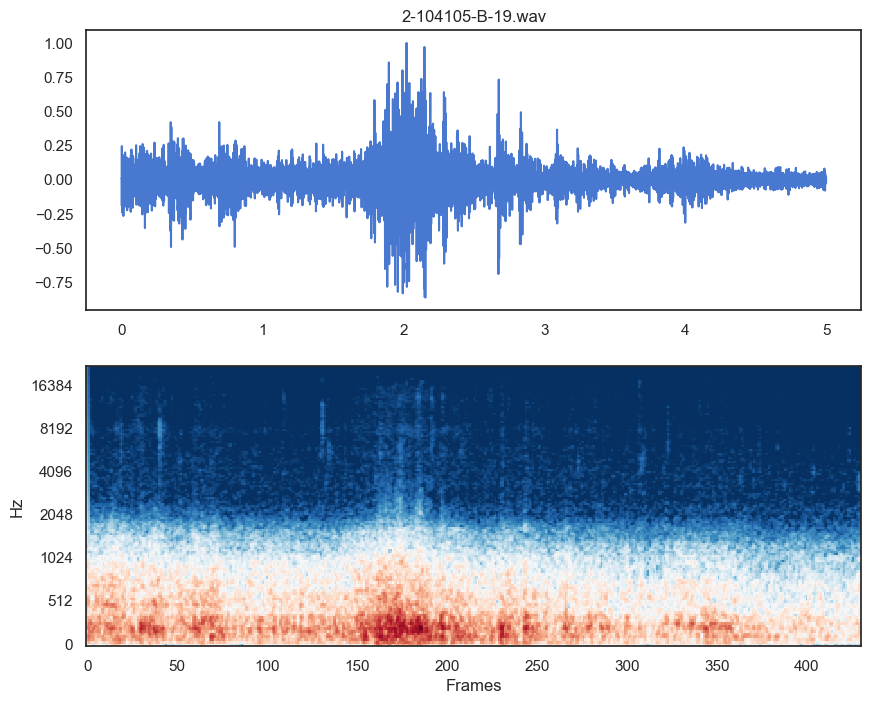

In [11]:
import IPython.display

# all_recordings = glob.glob('ESC-50-master/audio/*.wav')
# ESC-50-master\audio\2-104105-B-19.wav
all_recordings = glob.glob('ESC-50-master/audio/2-104105-B-19.wav')
clip = Clip(all_recordings[random.randint(0, len(all_recordings) - 1)])    

with clip.audio as audio:
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    plt.title('{0}'.format(clip.filename))
    plt.plot(np.arange(0, len(audio.raw)) / 44100.0, audio.raw)
   
    plt.subplot(2, 1, 2)
    librosa.display.specshow(librosa.power_to_db(clip.melspectrogram, ref=np.max), sr=44100, x_axis='frames', y_axis='mel', cmap='RdBu_r')

    # change the height of the figure

IPython.display.Audio(filename=clip.path, rate=Clip.RATE)    


In [12]:
esc_csv = pd.read_csv('ESC-50-master/meta/esc50.csv')
esc_csv.head()

filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

In [13]:
# target represents the class of each audio
def load_dataset(name):
    """Load all dataset recordings into a nested list."""
    # 50 classes and 10 clips for each class
    clips = []

    for i in range(50):
      class_clips = []
      for clip_filename in esc_csv[esc_csv["target"] == i]["filename"]:
        class_clips.append(Clip('{0}/{1}'.format(name, clip_filename)))
      print('All {0}/50 class recordings loaded.'.format(i+1))   
      clips.append(class_clips)
    return clips

clips_50 = load_dataset('ESC-50-master/audio')


All 1/50 class recordings loaded.
All 2/50 class recordings loaded.
All 3/50 class recordings loaded.
All 4/50 class recordings loaded.
All 5/50 class recordings loaded.
All 6/50 class recordings loaded.
All 7/50 class recordings loaded.
All 8/50 class recordings loaded.
All 9/50 class recordings loaded.
All 10/50 class recordings loaded.
All 11/50 class recordings loaded.
All 12/50 class recordings loaded.
All 13/50 class recordings loaded.
All 14/50 class recordings loaded.
All 15/50 class recordings loaded.
All 16/50 class recordings loaded.
All 17/50 class recordings loaded.
All 18/50 class recordings loaded.
All 19/50 class recordings loaded.
All 20/50 class recordings loaded.
All 21/50 class recordings loaded.
All 22/50 class recordings loaded.
All 23/50 class recordings loaded.
All 24/50 class recordings loaded.
All 25/50 class recordings loaded.
All 26/50 class recordings loaded.
All 27/50 class recordings loaded.
All 28/50 class recordings loaded.
All 29/50 class recordings lo

In [14]:
for i in clips_50:
    for clip in i:
        # Locate row in esc_csv with the same filename as clip
        row = esc_csv.loc[esc_csv['filename'] == clip.filename]
        # Replace category with the one in esc_csv
        categoria = str(row['category'].values[0])
        print(categoria)
        clip.category = clip.category.replace('c:\\Users\\matti\\Documents\\GitHub\\HDA_project\\ESC-50-master\\audio', categoria)

clips_50[2][0].category

dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
rooster
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
pig
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
cow
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog
frog


'pig'

In [15]:
def add_subplot_axes(ax, position):
    box = ax.get_position()
    
    position_display = ax.transAxes.transform(position[0:2])
    position_fig = plt.gcf().transFigure.inverted().transform(position_display)
    x = position_fig[0]
    y = position_fig[1]
    
    return plt.gcf().add_axes([x, y, box.width * position[2], box.height * position[3]])

In [31]:
clips_50[0]

[<1-100032-A-0.wav>,
 <1-110389-A-0.wav>,
 <1-30226-A-0.wav>,
 <1-30344-A-0.wav>,
 <1-32318-A-0.wav>,
 <1-59513-A-0.wav>,
 <1-85362-A-0.wav>,
 <1-97392-A-0.wav>,
 <2-114280-A-0.wav>,
 <2-114587-A-0.wav>,
 <2-116400-A-0.wav>,
 <2-117271-A-0.wav>,
 <2-118072-A-0.wav>,
 <2-118964-A-0.wav>,
 <2-122104-A-0.wav>,
 <2-122104-B-0.wav>,
 <3-136288-A-0.wav>,
 <3-144028-A-0.wav>,
 <3-155312-A-0.wav>,
 <3-157695-A-0.wav>,
 <3-163459-A-0.wav>,
 <3-170015-A-0.wav>,
 <3-180256-A-0.wav>,
 <3-180977-A-0.wav>,
 <4-182395-A-0.wav>,
 <4-183992-A-0.wav>,
 <4-184575-A-0.wav>,
 <4-191687-A-0.wav>,
 <4-192236-A-0.wav>,
 <4-194754-A-0.wav>,
 <4-199261-A-0.wav>,
 <4-207124-A-0.wav>,
 <5-203128-A-0.wav>,
 <5-203128-B-0.wav>,
 <5-208030-A-0.wav>,
 <5-212454-A-0.wav>,
 <5-213855-A-0.wav>,
 <5-217158-A-0.wav>,
 <5-231762-A-0.wav>,
 <5-9032-A-0.wav>]

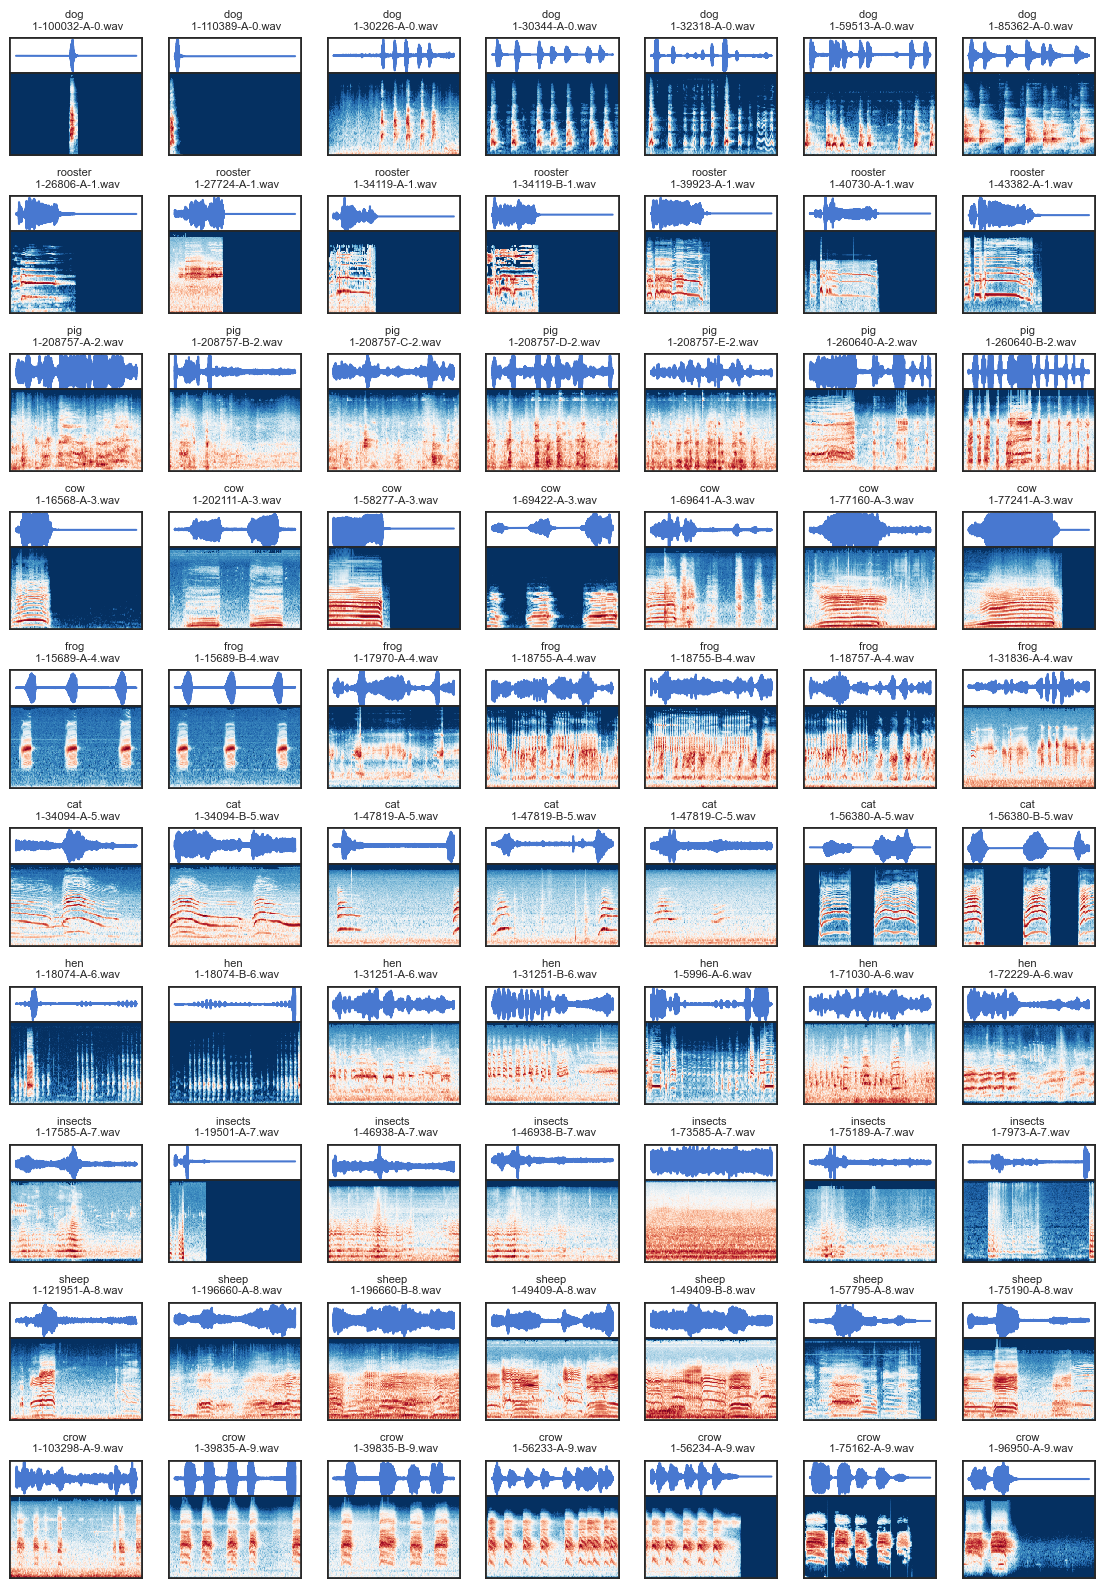

In [25]:
def plot_clip_overview(clip, ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax_waveform = add_subplot_axes(ax, [0.0, 0.7, 1.0, 0.3])
    ax_spectrogram = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.7])
    
    with clip.audio as audio:
        ax_waveform.plot(np.arange(0, len(audio.raw)) / float(Clip.RATE), audio.raw)
        ax_waveform.get_xaxis().set_visible(False)
        ax_waveform.get_yaxis().set_visible(False)
        ax_waveform.set_title('{0} \n {1}'.format(clip.category, clip.filename), {'fontsize': 8}, y=1.03)

        librosa.display.specshow(librosa.power_to_db(clip.melspectrogram, ref=np.max), sr=44100, x_axis='frames', y_axis='mel', cmap='RdBu_r')
        ax_spectrogram.get_xaxis().set_visible(False)
        ax_spectrogram.get_yaxis().set_visible(False)
        ax_spectrogram.set_facecolor('w')

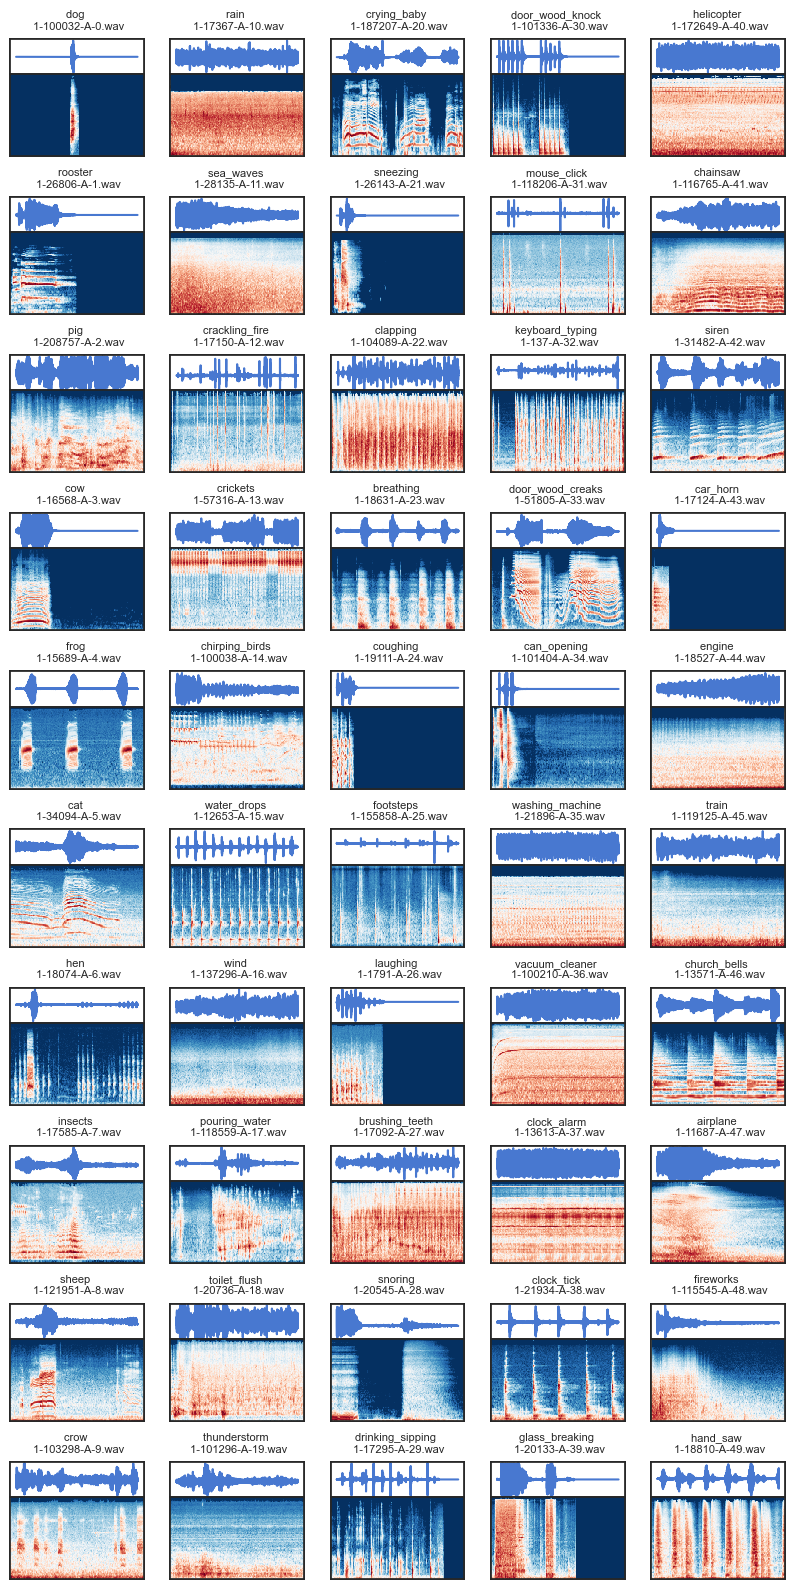

In [85]:
f, axes = plt.subplots(10, 5, figsize=(5 * 2, 10 * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for row in range(0, 10):
    for col in range(0, 5):
        plot_clip_overview(clips_50[col * 10 + row][0], axes[row, col])

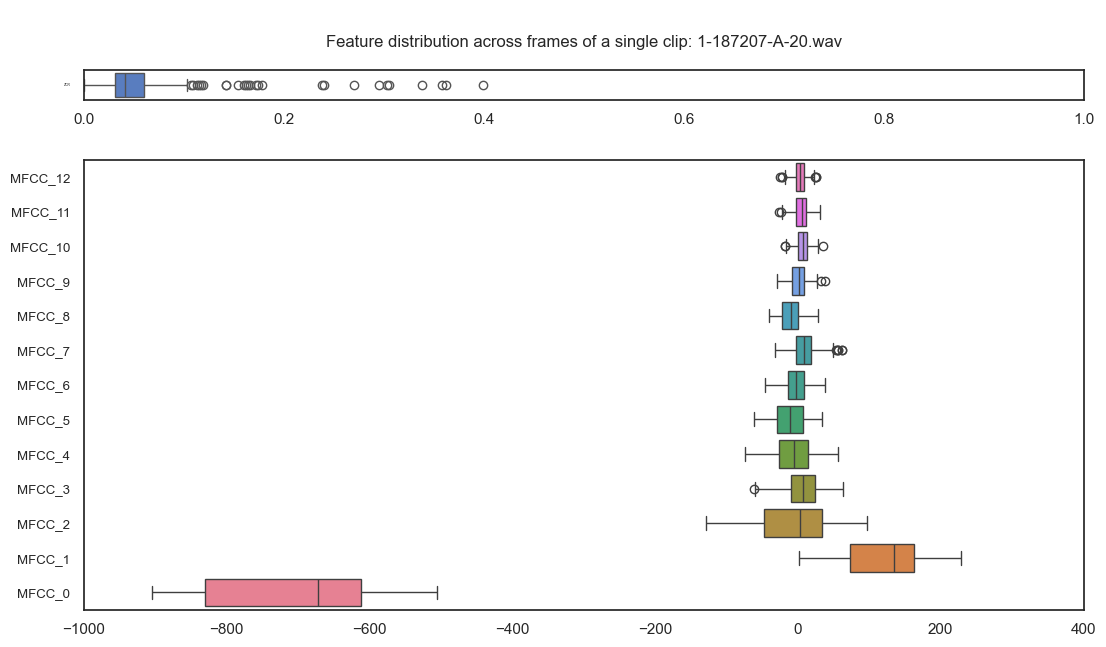

In [90]:
def plot_single_clip(clip):
    col_names = list('MFCC_{}'.format(i) for i in range(np.shape(clip.mfcc)[1]))
    mod_mfcc = librosa.feature.mfcc(S=librosa.power_to_db(clip.melspectrogram, ref=np.max), n_mfcc=13).transpose()
   
    #mod_mfcc = clip.mfcc
    MFCC = pd.DataFrame(mod_mfcc[:, :], columns=col_names)

    f = plt.figure(figsize=(10, 6))
    ax = f.add_axes([0.0, 0.0, 1.0, 1.0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_frame_on(False)

    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 1.0, 0.75])
    ax_mfcc.set_xlim(-1000, 400)
    ax_zcr = add_subplot_axes(ax, [0.0, 0.85, 1.0, 0.05])
    ax_zcr.set_xlim(0.0, 1.0)

    plt.title('Feature distribution across frames of a single clip: {0}'.format(clip.filename), y=1.5)
    sb.boxplot(MFCC, orient='h', order=list(reversed(MFCC.columns)), ax=ax_mfcc)
    sb.boxplot(pd.DataFrame(clip.zcr, columns=['ZCR']), orient='h', ax=ax_zcr)
    
plot_single_clip(clips_50[20][0])

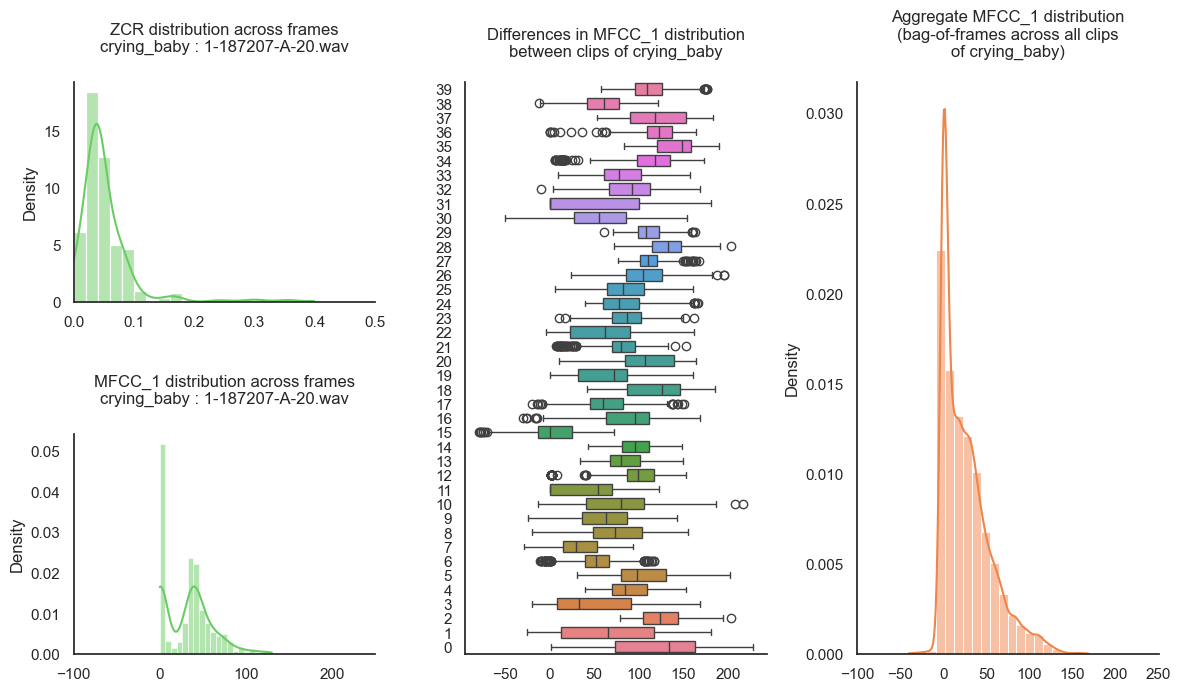

In [130]:
def plot_single_feature_one_clip(feature, title, ax):
    sb.despine()
    ax.set_title(title, y=1.10)
    sb.histplot(feature, bins=20, stat="density", kde=True, ax=ax,
                color=sb.color_palette("muted", 4)[2])
                

def plot_single_feature_all_clips(feature, title, ax):
    sb.despine()
    ax.set_title(title, y=1.03)
    ax.set_xticks(np.arange(-300, +300,50))
    sb.boxplot(data=feature, orient="h", order=list(reversed(feature.columns)), ax=ax)

def plot_single_feature_aggregate(feature, title, ax):    
    sb.despine()
    ax.set_title(title, y=1.03)
    ax.set_xticks(np.arange(-100, +300,50))
    sb.histplot(feature, bins=20, stat="density", kde=True, ax=ax,
                color=sb.color_palette("muted", 4)[1])

def generate_feature_summary(category, clip, coefficient, clips_50):
    title = "{0} : {1}".format(clips_50[category][clip].category, clips_50[category][clip].filename)
    MFCC = pd.DataFrame()
    aggregate = []
    for i in range(0, len(clips_50[category])):
        MFCC[i] = librosa.feature.mfcc(S=librosa.power_to_db(clips_50[category][i].melspectrogram), n_mfcc=13).transpose()[:, coefficient]
        aggregate = np.concatenate([aggregate, clips_50[category][i].mfcc[:, coefficient]])    

    f = plt.figure(figsize=(14, 12))
    f.subplots_adjust(hspace=0.6, wspace=0.3)

    ax1 = plt.subplot2grid((3, 3), (0, 0))
    ax2 = plt.subplot2grid((3, 3), (1, 0))
    ax3 = plt.subplot2grid((3, 3), (0, 1), rowspan=2)
    ax4 = plt.subplot2grid((3, 3), (0, 2), rowspan=2)

    ax1.set_xlim(0.0, 0.5)
    ax2.set_xlim(-100, 250)
    ax4.set_xlim(-100, 250)
    
    plot_single_feature_one_clip(clips_50[category][clip].zcr, 'ZCR distribution across frames\n{0}'.format(title), ax1)
    plot_single_feature_one_clip(clips_50[category][clip].mfcc[:, coefficient], 'MFCC_{0} distribution across frames\n{1}'.format(coefficient, title), ax2)

    plt.sca(ax3)  # Set the current Axes
    plot_single_feature_all_clips(MFCC, 'Differences in MFCC_{0} distribution\nbetween clips of {1}'.format(coefficient, clips_50[category][clip].category), plt.gca())

    plt.sca(ax4)  # Set the current Axes
    plot_single_feature_aggregate(aggregate, 'Aggregate MFCC_{0} distribution\n(bag-of-frames across all clips\nof {1})'.format(coefficient, clips_50[category][clip].category), plt.gca())

generate_feature_summary(20, 0, 1, clips_50)

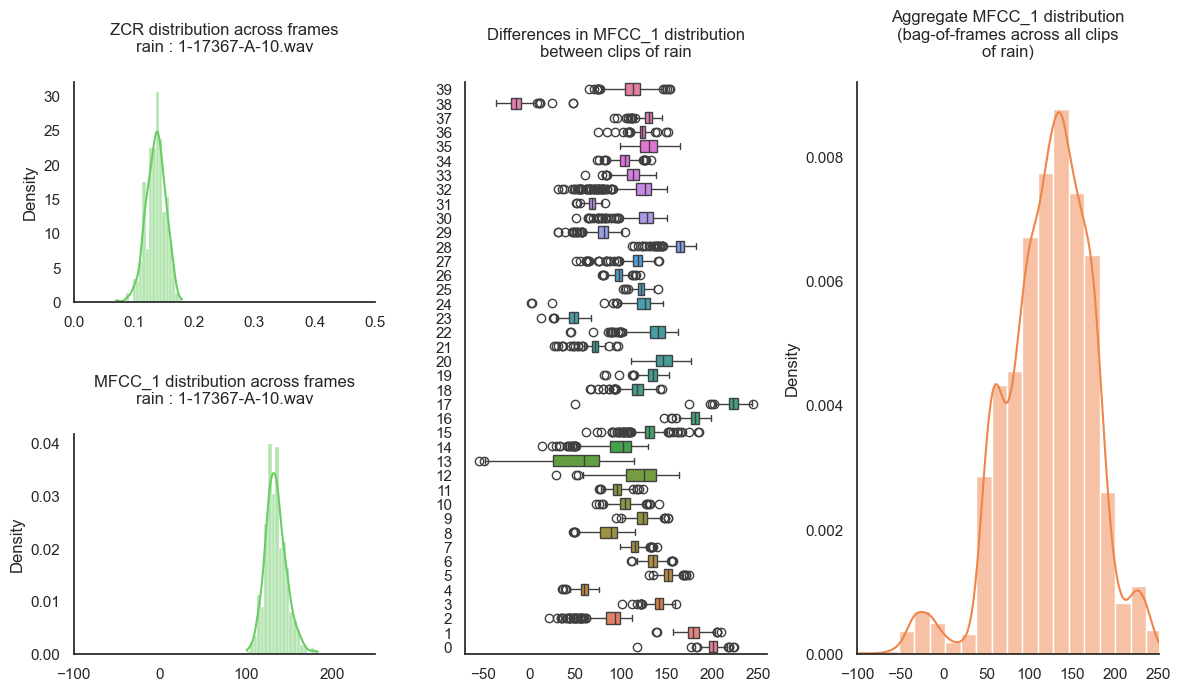

In [131]:
generate_feature_summary(10, 0, 1, clips_50)

C:\Users\matti\AppData\Local\Temp\ipykernel_10984\3251931787.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aggregated_mfcc = pd.concat([aggregated_mfcc, df], ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_10984\3251931787.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_mfcc.set_xticklabels(range(0, 13), rotation=90, fontsize=8)
C:\Users\matti\AppData\Local\Temp\ipykernel_10984\3251931787.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, e

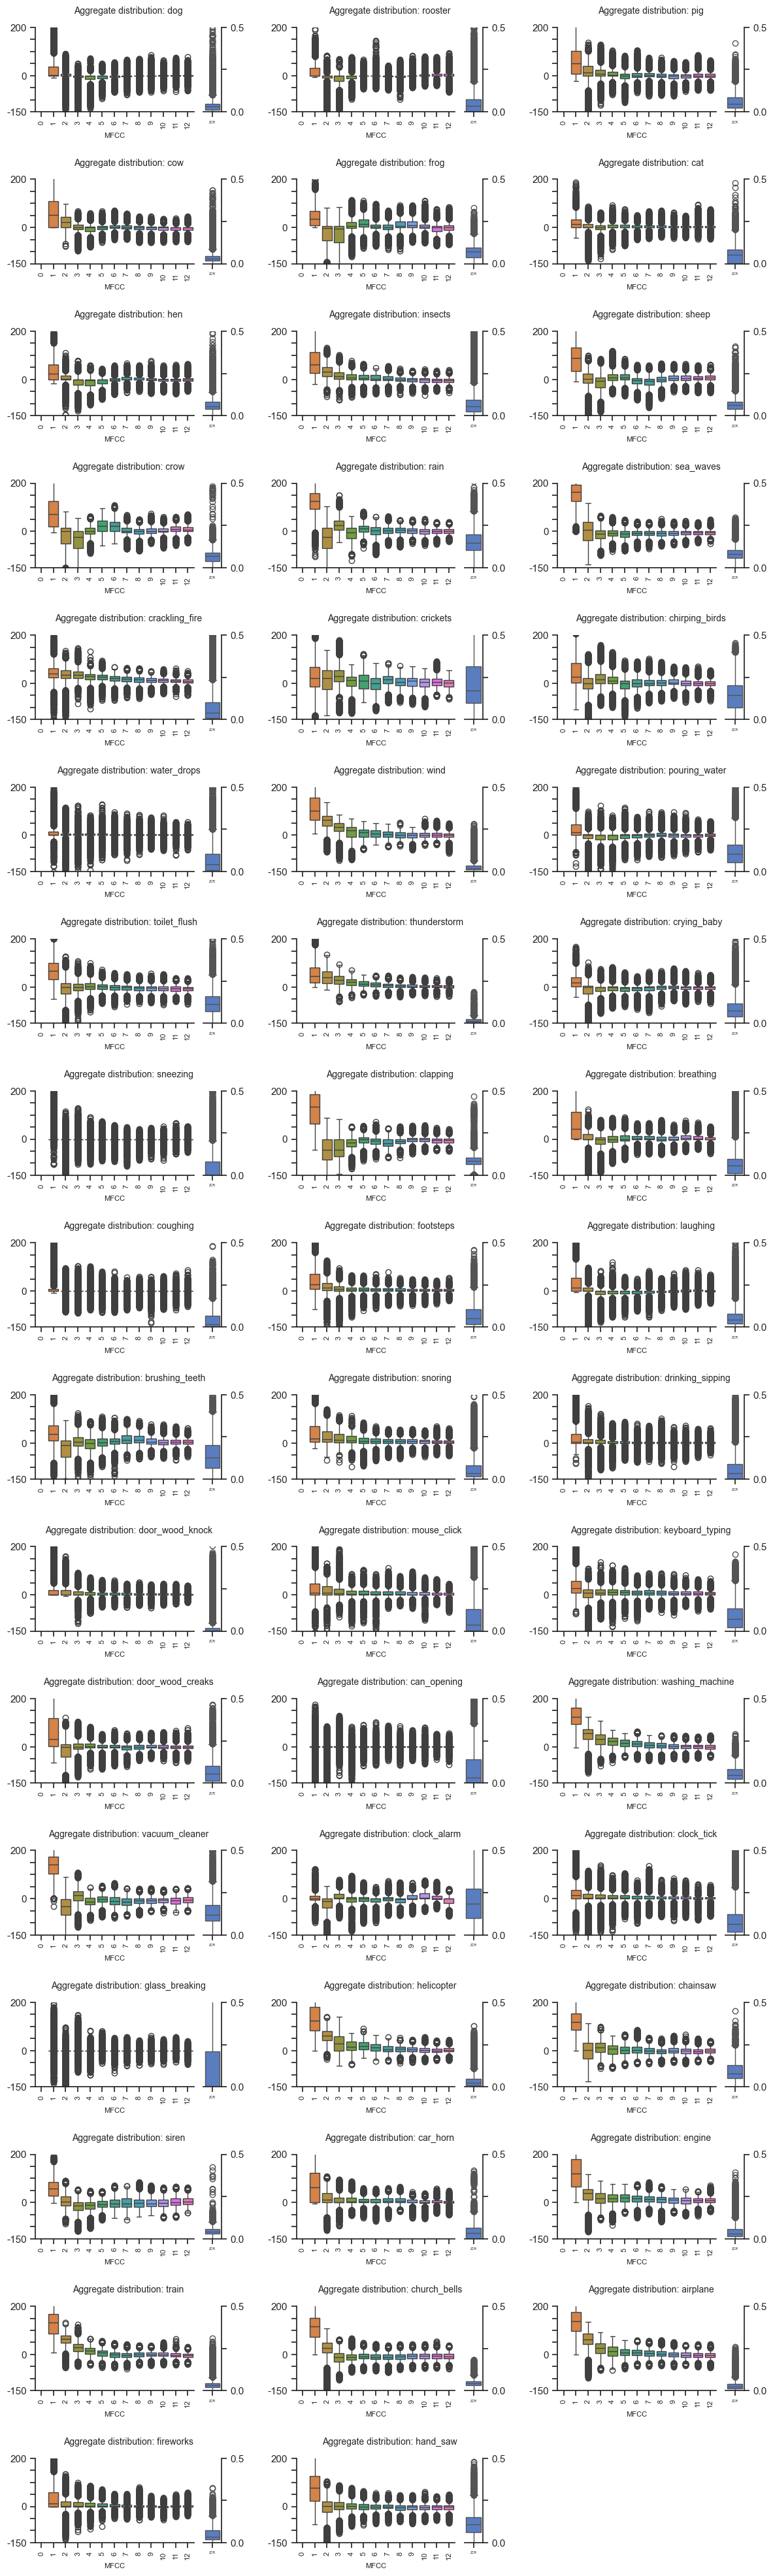

In [144]:
def plot_all_features_aggregate(clips, ax):
    ax_mfcc = add_subplot_axes(ax, [0.0, 0.0, 0.85, 1.0])
    ax_zcr = add_subplot_axes(ax, [0.9, 0.0, 0.1, 1.0])
    
    sb.set_style('ticks')
    
    col_names = list('MFCC_{}'.format(i) for i in range(np.shape(clips[0].mfcc)[1]))
    aggregated_mfcc = pd.DataFrame(clips[0].mfcc[:, :], columns=col_names)

    for i in range(1, len(clips)):
        df = pd.DataFrame(clips[i].mfcc[:, :], columns=col_names)
        if df is not None:
            aggregated_mfcc = aggregated_mfcc.append(df)
        
    aggregated_zcr = pd.DataFrame(clips[0].zcr, columns=['ZCR']) 
    for i in range(1, len(clips)):
        df = pd.DataFrame(clips[i].zcr, columns=['ZCR'])
        if df is not None:
            aggregated_zcr = aggregated_zcr.append(df)
    
    sb.despine(ax=ax_mfcc)
    ax.set_title('Aggregate distribution: {0}'.format(clips[0].category), y=1.10, fontsize=10)
    sb.boxplot(aggregated_mfcc, vert=True, order=aggregated_mfcc.columns, ax=ax_mfcc)
    ax_mfcc.set_xticklabels(range(0, 13), rotation=90, fontsize=8)
    ax_mfcc.set_xlabel('MFCC', fontsize=8)
    ax_mfcc.set_ylim(-150, 200)
    ax_mfcc.set_yticks((-150, -100, -50, 0, 50, 100, 150, 200))
    ax_mfcc.set_yticklabels(('-150', '', '', '0', '', '', '', '200'))
    
    sb.despine(ax=ax_zcr, right=False, left=True)
    sb.boxplot(aggregated_zcr, vert=True, order=aggregated_zcr.columns, ax=ax_zcr)
    ax_zcr.set_ylim(0.0, 0.5)
    ax_zcr.set_yticks((0.0, 0.25, 0.5))
    ax_zcr.set_yticklabels(('0.0', '', '0.5'))

categories = 50
    
f, axes = plt.subplots(int(np.ceil(categories / 3.0)), 3, figsize=(14, categories * 1))
f.subplots_adjust(hspace=0.8, wspace=0.4)

[ax.get_xaxis().set_visible(False) for ax in axes.flat]
[ax.get_yaxis().set_visible(False) for ax in axes.flat]
[ax.set_frame_on(False) for ax in axes.flat]

for c in range(0, categories):
    plot_all_features_aggregate(clips_50[c], axes.flat[c])


In [167]:
def plot_features_scatter(feature1, feature2, category, category_name, ax, legend='small',
                          pretty_labels=None, font=None, crop_right=None):
    if font is None:
        font = matplotlib.font_manager.FontProperties()
   
    sb.despine()
    category_count = len(category.unique())
    colors = sb.color_palette("Set3", 10)
    plots = []
    labels = []
    markers = [
    '^',  # Triangle up
    's',  # Square
    'v',  # Triangle down
    '>',  # Triangle right
    '*',  # Star
    '<',  # Triangle left
    'p',  # Pentagon
    'o',  # Circle
    '8',  # Octagon
    'o',  # Circle (again, in case there are more than 9 categories)
]

    
    for c in range(0, category_count):
        f1 = feature1[category == c]
        f2 = feature2[category == c]
        size = 50 if c != 9 else 35
        plots.append(ax.scatter(f1, f2, c=colors[c], s=size, marker=markers[c]))
        labels.append(category_name[category == c].iloc[0][6:] if not category_name[category == c].empty else '')


    font.set_size(11)
    ax.set_xlabel(feature1.name, fontproperties=font)
    ax.set_ylabel(feature2.name, fontproperties=font)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] * 1.3)
    ax.set_xticklabels(ax.get_xticks(), fontproperties=font)
    ax.set_yticklabels(ax.get_yticks(), fontproperties=font)
    
    if crop_right is not None:
        ax.set_xlim(ax.get_xlim()[0], crop_right)
    
    if pretty_labels is not None:
        labels = pretty_labels
    
    if legend == 'small':
        ax.legend(plots, labels, ncol=2, loc='upper center', frameon=False, fancybox=False, borderpad=1.0, prop=font)
    elif legend == 'big':
        font.set_size(11)
        ax.legend(plots, labels, ncol=5, columnspacing=2, markerscale=1.5, loc='upper center', frameon=False, fancybox=False, borderpad=1.0, prop=font)


In [158]:
print(clip_features.columns)


Index(['MFCC_0_mean', 'MFCC_1_mean', 'MFCC_2_mean', 'MFCC_3_mean',
       'MFCC_4_mean', 'MFCC_5_mean', 'MFCC_6_mean', 'MFCC_7_mean',
       'MFCC_8_mean', 'MFCC_9_mean', 'MFCC_10_mean', 'MFCC_11_mean',
       'MFCC_12_mean', 'MFCC_0_std_dev', 'MFCC_1_std_dev', 'MFCC_2_std_dev',
       'MFCC_3_std_dev', 'MFCC_4_std_dev', 'MFCC_5_std_dev', 'MFCC_6_std_dev',
       'MFCC_7_std_dev', 'MFCC_8_std_dev', 'MFCC_9_std_dev', 'MFCC_10_std_dev',
       'MFCC_11_std_dev', 'MFCC_12_std_dev', 'ZCR_mean', 'ZCR_std_dev',
       'category', 'category_name', 'clip'],
      dtype='object')


Da modificare per rendere visibile però dovrebbe funzionare, solo che originariamente era pensato per esc-10 dato che ha 10 classi, questo ne ha 50.

C:\Users\matti\AppData\Local\Temp\ipykernel_10984\234476567.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clip_features = pd.concat([clip_features, current], ignore_index=True)
C:\Users\matti\AppData\Local\Temp\ipykernel_10984\3642493629.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plots.append(ax.scatter(f1, f2, c=colors[c], s=size, marker=markers[c]))
C:\Users\matti\AppData\Local\Temp\ipykernel_10984\3642493629.py:37: UserWarning: set_ticklabe

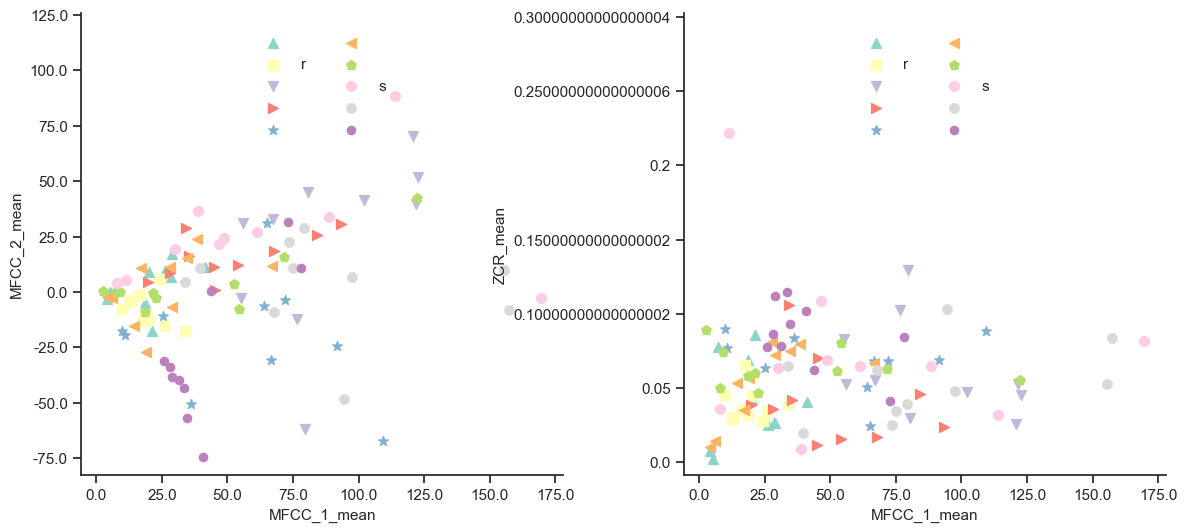

In [169]:
import matplotlib.font_manager

clip_features = pd.DataFrame(columns=col_names_mean + col_names_std + ['ZCR_mean', 'ZCR_std_dev', 'category', 'category_name', 'clip'])

for c in range(0, 10):  # altrimenti diventano troppi, visualiziamo solo 10 categorie.
    for i in range(0, 10):
        col_names_mean = list('MFCC_{}_mean'.format(i) for i in range(np.shape(clips_50[c][i].mfcc)[1]))
        col_names_std = list('MFCC_{}_std_dev'.format(i) for i in range(np.shape(clips_50[c][i].mfcc)[1]))
        current_mean = pd.DataFrame(np.mean(clips_50[c][i].mfcc, axis=0)[np.newaxis, :], columns=col_names_mean)
        current_std = pd.DataFrame(np.std(clips_50[c][i].mfcc, axis=0)[np.newaxis, :], columns=col_names_std)
        current = pd.concat([current_mean, current_std], axis=1)
        current['ZCR_mean'] = np.mean(clips_50[c][i].zcr)
        current['ZCR_std_dev'] = np.std(clips_50[c][i].zcr)
        current['category'] = c
        current['category_name'] = clips_50[c][i].category
        current['clip'] = i
        clip_features = pd.concat([clip_features, current], ignore_index=True)

f, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_features_scatter(clip_features['MFCC_1_mean'], clip_features['MFCC_2_mean'], clip_features['category'], clip_features['category_name'], axes[0])
plot_features_scatter(clip_features['MFCC_1_mean'], clip_features['ZCR_mean'], clip_features['category'], clip_features['category_name'], axes[1])
plt.subplots_adjust(wspace=0.25)


# PCA

C:\Users\matti\AppData\Local\Temp\ipykernel_10984\3642493629.py:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plots.append(ax.scatter(f1, f2, c=colors[c], s=size, marker=markers[c]))
C:\Users\matti\AppData\Local\Temp\ipykernel_10984\3642493629.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontproperties=font)
C:\Users\matti\AppData\Local\Temp\ipykernel_10984\3642493629.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontproperties=font)


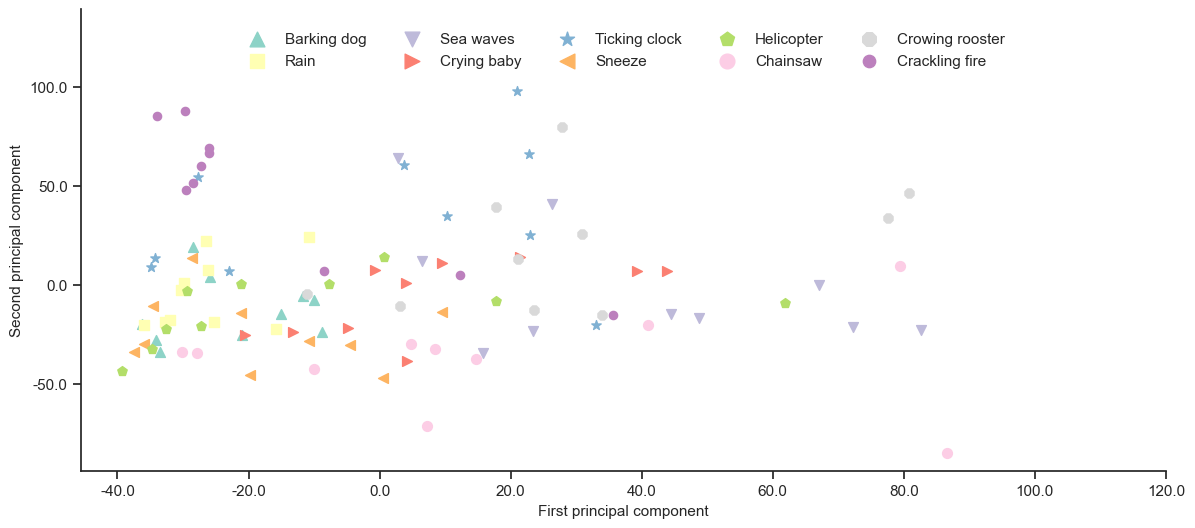

In [172]:
import sklearn as sk
import sklearn.decomposition

pca = sk.decomposition.PCA(n_components=2)
pca.fit(clip_features.loc[:, 'MFCC_1_mean':'ZCR_std_dev'])
X = pca.transform(clip_features.loc[:, 'MFCC_1_mean':'ZCR_std_dev'])
clip_features['First principal component'] = X[:, 0]
clip_features['Second principal component'] = X[:, 1]

f, axes = plt.subplots(1, 1, figsize=(14, 6))
pretty_labels = ['Barking dog', 'Rain', 'Sea waves', 'Crying baby', 'Ticking clock', 'Sneeze', 'Helicopter', 'Chainsaw', 'Crowing rooster', 'Crackling fire']

plot_features_scatter(clip_features['First principal component'], clip_features['Second principal component'],
                      clip_features['category'], clip_features['category_name'],
                      axes, 'big', pretty_labels, crop_right=150)

plt.savefig("figure_pca.pdf")